In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense, Reshape, Conv2DTranspose
from keras.optimizers import Adam, Adadelta
from keras.layers import Input, Embedding, Concatenate
from keras.models import Model
from tensorflow import ConfigProto
from tensorflow import InteractiveSession
from keras.models import load_model

from matplotlib import cm
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import pandas as pd
import os
from PIL import Image
import glob
from os import listdir
from os.path import isfile, join

Using TensorFlow backend.


In [3]:
# size of the latent space
latent_dim = 32

In [4]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
SX=64
SY=64
N_CHANNELS=1
EXTRINSIC_DIM=6 #LABELS, Y
LATENT_DIM = latent_dim

In [6]:
INPUT_SHAPE=(SX,SY,N_CHANNELS) #INPUT, X

In [7]:
# define the standalone discriminator model
def define_cond_discriminator(in_shape=INPUT_SHAPE, n_classes=EXTRINSIC_DIM):    
    # label input
    in_label = Input(shape=(EXTRINSIC_DIM,), name="Y_extrinsic")
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]

    li = Dense(n_nodes)(in_label)

    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    # image input
    in_image = Input(shape=in_shape, name="X")
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid',name="Discriminator")(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    #opt = Adadelta()

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [8]:
discriminator_model = define_cond_discriminator()

In [9]:
# define the standalone generator model
def define_cond_generator(latent_dim=LATENT_DIM, n_classes=EXTRINSIC_DIM):
    init_size=(16,16)

    # label input
    in_label = Input(shape=(EXTRINSIC_DIM,), name="Y_extrinsic")
    # linear multiplication
    n_nodes = init_size[0] * init_size[1]
    li = Dense(n_nodes)(in_label)

    # reshape to additional channel
    li = Reshape((init_size[0] , init_size[1], 1))(li)

    # image generator input
    in_lat = Input(shape=(latent_dim,), name="Z_latent")
    # foundation for 7x7 image
    n_nodes = 128 * n_nodes
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((init_size[0], init_size[1], 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same', name="X_generated")(gen)

    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

In [10]:
generator_model=define_cond_generator()

In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_cond_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [12]:
GAN = define_cond_gan(generator_model, discriminator_model)

# Loading data

crop images by 128 x 128, downsize to 64 x 64

In [57]:
DATA_PATH = ".."
IMAGE_SUBPATH=".."

df=pd.read_csv(os.path.join(DATA_PATH,".."),sep=";")

shuffling dataframe

In [15]:
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
df.columns

Index(['file name', 'sample id', 'position', 'temperature [C]',
       'Al-concentration [at.%]', 'O-concentration [at.%]',
       'ionization degree [a.u.]', 'average ion energy [eV]', 'pressure [Pa]'],
      dtype='object')

In [17]:
Y_COLUMNS=['temperature [C]',
       'Al-concentration [at.%]', 'O-concentration [at.%]',
       'ionization degree [a.u.]', 'average ion energy [eV]', 'pressure [Pa]']

In [18]:
scaler = MinMaxScaler()

C:\Users\bankollq\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


temperature [C]


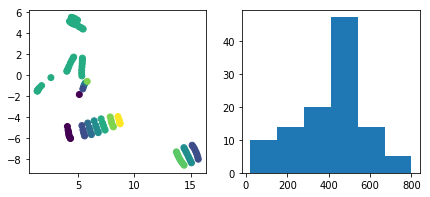

Al-concentration [at.%]


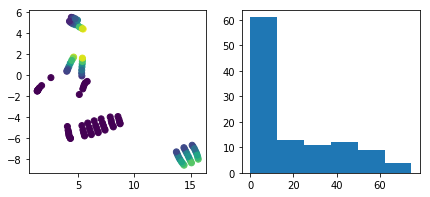

O-concentration [at.%]


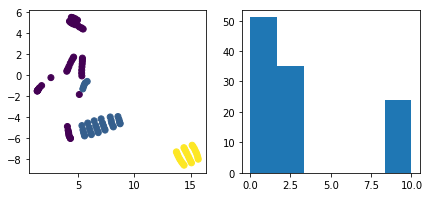

ionization degree [a.u.]


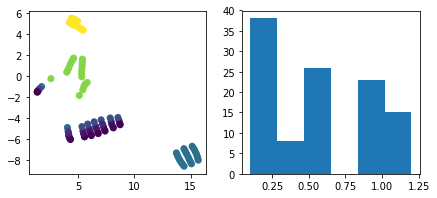

average ion energy [eV]


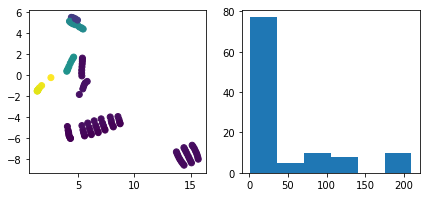

pressure [Pa]


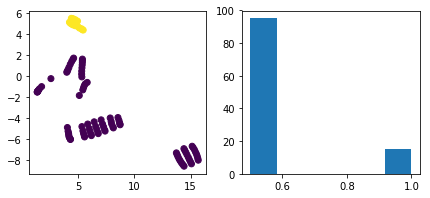

0 -> 15
16 -> 31
32 -> 47
48 -> 63
64 -> 79
80 -> 95
96 -> 109


In [19]:
y=df[Y_COLUMNS]

y_scaled=scaler.fit_transform(y)

tsne=TSNE()
y_tsne = tsne.fit_transform(y_scaled)

#number of bins per each extrinsic properties
BINS=6

for Y_column in Y_COLUMNS:
    print(Y_column)
    fig, axs= plt.subplots(1,2, figsize=(7,3))
    im=axs[0].scatter(y_tsne[:,0], y_tsne[:,1], c= df[Y_column]);
    h=axs[1].hist(df[Y_column], bins=BINS)
    plt.show()

binning_labels_dict={}
Y_COLUMNS_BINNING=[]
for Y_column in Y_COLUMNS:
    cnt,bins=np.histogram(df[Y_column], bins=BINS)
    bins[0]-=1
    col_name=Y_column+"_binning"
    binning_labels_dict[col_name] = np.searchsorted(bins, df[Y_column].values)
    Y_COLUMNS_BINNING.append(col_name)

binning_df=pd.DataFrame(binning_labels_dict)#.groupby(col_name).count()

binning_df["T"]=1

count_bins_df = binning_df.groupby(Y_COLUMNS_BINNING).count()

max_count=count_bins_df["T"].max()

df=pd.concat((df,binning_df),axis=1)

df=df.drop("T",axis=1)

count_bins_df=count_bins_df.reset_index()

df=pd.merge(df,count_bins_df,on=Y_COLUMNS_BINNING)

df["weight"] = max_count/df["T"]

## Image cropping & resizing 

BOX_SIZE=128
BATCH_SIZE=16
CROP_PER_IMAGE=128

batch_count = int(np.ceil(len(df)/BATCH_SIZE))

YS = []
WEIGHTS=[]
XS = []

for b in range(0, batch_count):
    print(b*BATCH_SIZE,"->",min(len(df),b*BATCH_SIZE+BATCH_SIZE)-1)

    batch_indices = np.arange(b*BATCH_SIZE,min(len(df),b*BATCH_SIZE+BATCH_SIZE))


    for ind in batch_indices:    
        fname=df.loc[ind,"file name"]
        fname=os.path.join(DATA_PATH,IMAGE_SUBPATH,fname)
        im=Image.open(fname)
        for rep in range(CROP_PER_IMAGE):        
            left=np.random.randint(0,im.width-BOX_SIZE)
            upper=np.random.randint(0,im.height-BOX_SIZE)

            box=left, upper, left+BOX_SIZE, upper+BOX_SIZE

            sub_image=im.crop(box)

            sub_image=sub_image.resize((SX,SY),resample=Image.ANTIALIAS)

            sub_image_np=np.array(sub_image)
            sub_image_np=((sub_image_np-127.5)/127.5).reshape(SX,SY,1)
            YS.append(df.loc[ind,Y_COLUMNS].values)
            WEIGHTS.append(df.loc[ind,"weight"])
            XS.append(sub_image_np)






In [20]:
YS = np.array(YS)
XS = np.array(XS)
WEIGHTS = np.array(WEIGHTS)

In [21]:
YS_scaled=scaler.fit_transform(YS)

C:\Users\bankollq\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [22]:
dataset=(XS,YS_scaled,WEIGHTS)

# Train

In [23]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels, weights = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels,weights = images[ix], labels[ix], weights[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y, weights

In [24]:
EXTRINSIC_DIM

6

In [25]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=EXTRINSIC_DIM):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.choice(len(YS),size=n_samples)
    weights = WEIGHTS[labels]
    labels=YS_scaled[labels]    
    return z_input, labels,weights

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input,weights_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y,weights_input

In [26]:
latent_dim

32

In [27]:
n_batch=128
half_batch = int(n_batch / 2)

In [28]:
n_samples=half_batch
n_samples

64

In [29]:
def gSZD_imscatter(x, y,img, ax,zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
#        img = imageData[i]*255.
#        img = img.astype(np.uint8).reshape([160,160])
#        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
#        image = img
        #----
        #lat=c_model.predict(np.reshape(latvec1[:,i],(1,5)))
        image = img[i].reshape(plen, plen)
       # image = cv2.cvtColor(image*255,cv2.COLOR_GRAY2RGB)
        # Note: OpenCV uses BGR and plt uses RGB
        image = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

In [30]:
def create_randuni_process_vector(num_samples, set_zero,addition):
    process_vector = np.concatenate([
        np.reshape(np.random.uniform(20,600,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0,70,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0,10,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0.1,1.2,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(1,200,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0.5,1,num_samples),(num_samples,1))
    ],axis=1)
    process_vector = np.reshape(process_vector,(num_samples,6))
    process_vector[:,set_zero]=0
    if addition is not None and len(addition)>0:
        process_vector[:,:]=process_vector[:,:]+addition
    process_vector = scaler.transform(process_vector)

    return process_vector

In [31]:
n_epochs=32

In [32]:
# function for trainining of generator and discriminator
def train_cgan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=32, verbose_freq=10, n_batch=32):
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    d_loss1_epochs=[]
    d_loss2_epochs=[]
    g_loss_epochs=[]
    d_loss1_batch=[]
    d_loss2_batch=[]
    g_loss_batch=[]
    
    
    # manually enumerate epochs
    iteration=0
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real, weights_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real, sample_weight=weights_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake, weights_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake, sample_weight=weights_fake)
            # prepare points in latent space as input for the generator
            z_input, labels_input, weights_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan,sample_weight=weights_gan)
            
            d_loss1_batch.append(d_loss1)
            d_loss2_batch.append(d_loss2)
            g_loss_batch.append(g_loss)
        

            
            if (iteration%verbose_freq==0):
                if ax.lines:
                    epochs_x=(np.arange(len(d_loss2_batch))+1)/bat_per_epo
                    for line,ydata in zip(ax.lines,[d_loss1_batch, d_loss2_batch,g_loss_batch]):
                        line.set_xdata(epochs_x)
                        line.set_ydata(ydata) 
                    ax.set_xlim(0,max(epochs_x)+1/bat_per_epo)
                    ax.set_ylim(0.9*min([min(d_loss1_batch),min(d_loss2_batch),min(g_loss_batch)]),1.1*max([max(d_loss1_batch), max(d_loss2_batch), max(g_loss_batch)]))
                else:
                    ax.plot(d_loss1_batch, label="d_loss_real")
                    ax.plot(d_loss2_batch, label="d_loss_fake")
                    ax.plot(g_loss_batch, label="g_loss")                 
                    fig.legend()
                fig.canvas.draw()
                
            iteration+=1
            
    if ax.lines:        
        epochs_x=(np.arange(len(d_loss2_batch))+1)/bat_per_epo
        for line,ydata in zip(ax.lines,[d_loss1_batch, d_loss2_batch,g_loss_batch]):
            line.set_xdata(epochs_x)
            line.set_ydata(ydata) 
        ax.set_xlim(0,max(epochs_x)+1/bat_per_epo)
        ax.set_ylim(0.9*min([min(d_loss1_batch),min(d_loss2_batch),min(g_loss_batch)]),1.1*max([max(d_loss1_batch), max(d_loss2_batch), max(g_loss_batch)]))
    else:
        ax.plot(d_loss1_batch, label="d_loss_real")
        ax.plot(d_loss2_batch, label="d_loss_fake")
        ax.plot(g_loss_batch, label="g_loss")                 
        fig.legend()
    fig.canvas.draw()

In [33]:
total_batch = 0
total_epochs = 0

In [34]:
n_batch = 128
n_epochs = 32

# train model



In [35]:
savename = 'SZD_cGAN'

In [36]:
import imageio

Run window below to train

%matplotlib notebook
# train model
n_runs = 16

#train model for n_runs * n_epochs
for k in range(n_runs):
    total_batch=total_batch+(dataset[0].shape[0] / n_batch) * n_epochs
    print(total_batch)

    train_cgan(generator_model, discriminator_model,GAN, dataset, latent_dim)
    
    #plot SZD after each run
    plt.gray()
    num_pred = 4000
    plen = 64

    latent_points, labels, _ = generate_latent_points(latent_dim, num_pred)
    del labels


    add_ = [0,0,1.0,1.0,7,0.5]
    pp = create_randuni_process_vector(num_pred,[2,3,4,5],add_)
    X_test  = generator_model.predict([latent_points, pp])
    # scale from [-1,1] to [0,1]
    #X_test = (X_test + 1) / 2.0 
    pp=scaler.inverse_transform(pp)

    #pr_inv_trans=p_scaler.inverse_transform(z_pred[:,100:])
    fig, ax = plt.subplots(figsize=(15, 12))
    gSZD_imscatter(pp[:,0],pp[:,1],X_test,ax,.5)
    plt.ylabel('Al-concentration [at.%]')#,fontsize=20)
    plt.tick_params(axis='both', which='major')#, labelsize=20)
    plt.xlabel('deposition temperature [°C]')#,fontsize=20)
    plt.savefig('SZD_'+str(total_batch)+'_'+'_O_'+str(add_[2])+ '_Id_'+str(add_[3])+ '_E '+str(add_[4])+'_P_'+str(add_[5])+'.png',dpi = 150)

    # save models
    generator_model.save(savename+'_total_batches_'+str(total_batch) + 'cgan_SZD_generator.h5')
    discriminator_model.save(savename+'_total_batches_'+str(total_batch) + ' cgan_SZD_discriminator.h5')
    GAN.save(savename+'_total_batches_'+str(total_batch) + 'cgan_SZD_gan.h5')


### Load trained generator model

In [40]:
generator_model = load_model('...h5')

C:\Users\bankollq\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Visualization of generated Structure Zone Diagrams (gSZD)


In [43]:
%matplotlib inline

### gSZD for Al(T)
- 1 at% O
- 1.0 ionization degree
- 7 eV ion energy
- 0.5 Pa pressure

Text(0.5, 0, 'deposition temperature [°C]')

<Figure size 432x288 with 0 Axes>

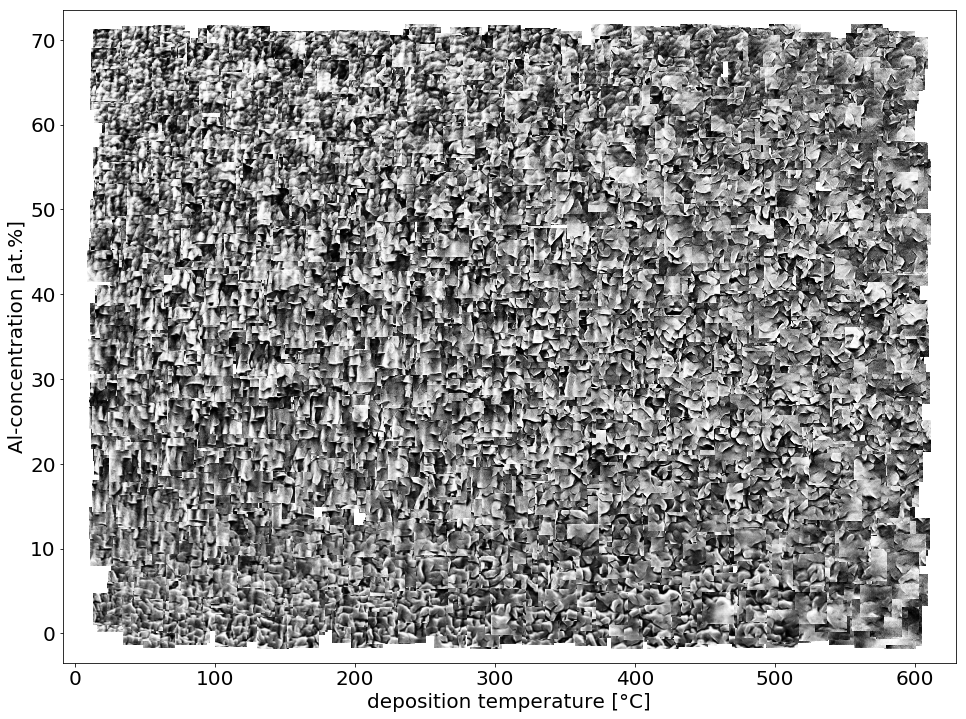

In [47]:
plt.gray()
num_pred = 3000
plen = 64

latent_points, labels, weights = generate_latent_points(latent_dim, num_pred)
del labels

add_ = [0,0,1.0,1.0,40,0.5]
pp = create_randuni_process_vector(num_pred,[2,3,4,5],add_)
X_test  = generator_model.predict([latent_points, pp])
# scale from [-1,1] to [0,1]
X_test = (X_test + 1) / 2.0 
pp=scaler.inverse_transform(pp)

fig, ax = plt.subplots(figsize=(16, 12))
gSZD_imscatter(pp[:,0],pp[:,1],X_test,ax,.5)
plt.ylabel('Al-concentration [at.%]',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('deposition temperature [°C]',fontsize=20)


### gSZD for E(T)
- 1 at% O
- 60 at.% Al
- 1.0 ionization degree
- 0.5 Pa pressure

Text(0.5, 0, 'deposition temperature [°C]')

<Figure size 432x288 with 0 Axes>

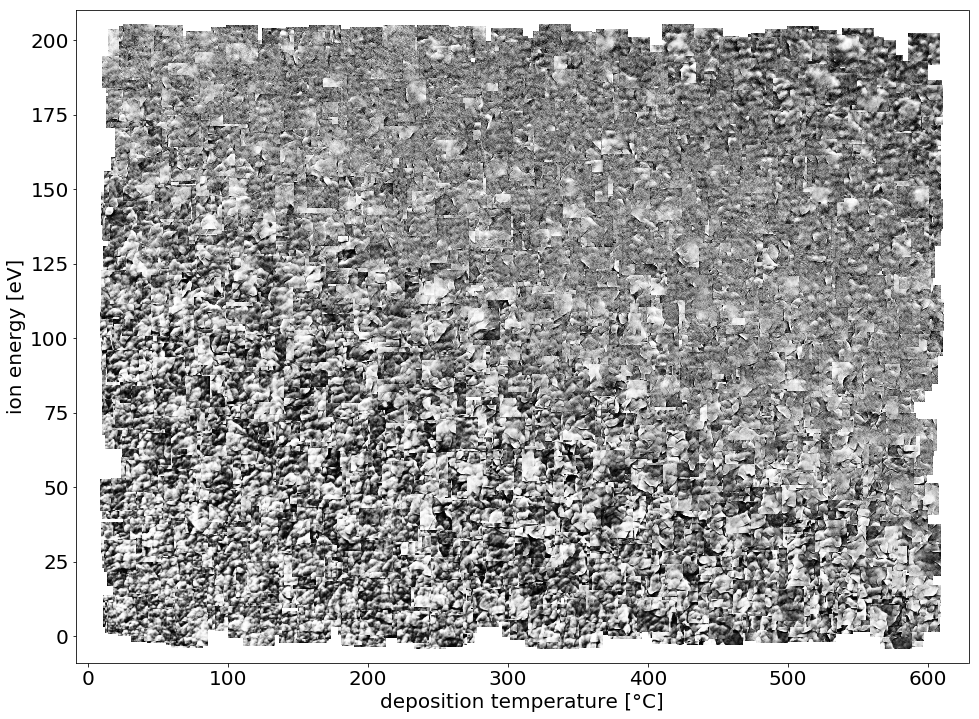

In [45]:
plt.gray()
num_pred = 3000
latent_points, labels, weights = generate_latent_points(latent_dim, num_pred)
add_ = [0,60.0,1.0,1.0,0,0.5]
pp = create_randuni_process_vector(num_pred,[1,2,3,5],add_)

X_test  = generator_model.predict([latent_points, pp])

# scale from [-1,1] to [0,1]
X_test = (X_test + 1) / 2.0 
pp_=scaler.inverse_transform(pp)

#pr_inv_trans=p_scaler.inverse_transform(z_pred[:,100:])
fig, ax = plt.subplots(figsize=(16, 12))
gSZD_imscatter(pp_[:,0],pp_[:,4],X_test,ax,.5)
plt.ylabel('ion energy [eV]',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('deposition temperature [°C]',fontsize=20)
#plt.savefig('SZD_ET'+f+'.png',dpi=100)

### save images for particle analysis


In [41]:
from PIL import Image

In [59]:
PARTICLE_IMAGE_PATH = '..'

In [60]:
num_gen=10 # sqrt of 
# generate images
latent_points, labels, weights = generate_latent_points(latent_dim, num_gen*num_gen)
print('results after '+str(total_batch)+' batches')
for ind in range(0, len(df), 1):
    fname=df.loc[ind,"file name"]
    fname_load=os.path.join(DATA_PATH,IMAGE_SUBPATH,fname)
    fname_save = os.path.join(PARTICLE_IMAGE_PATH,fname)

    l0=scaler.transform(df.loc[ind:ind,Y_COLUMNS])


    im=Image.open(fname_load)

    # crop patches and save 
    for i in range(0,num_gen*num_gen,1):
        left=np.random.randint(0,im.width-BOX_SIZE)
        upper=np.random.randint(0,im.height-BOX_SIZE)

        box=left, upper, left+BOX_SIZE, upper+BOX_SIZE

        sub_image=im.crop(box)
        sub_image=sub_image.resize((SX,SY),resample=Image.ANTIALIAS)
        sub_image_np=np.array(sub_image)
        #sub_image_np=((sub_image_np-0)/256).reshape(SX,SY)
        sub_image_np = Image.fromarray(sub_image_np.astype('uint8'),mode = 'L')
        sub_image_np.save(str(fname_save)+'_original_'+str(i)+'.png')
    
    # generate and save image patches
    labels=np.array([l0[0] for _ in range(num_gen*num_gen)])
    X_test  = generator_model.predict([latent_points, labels])
    X_test = (X_test + 1) / 2.0  *256
    for i in range(0,num_gen*num_gen,1):
        im = X_test[i,:,:,0]
        im = Image.fromarray(im.astype('uint8'),mode = 'L')
        im.save(str(fname_save)+'_predicted_'+str(i)+'.png')

results after 3520.0 batches


### perform particle analysis using fiji macro (external) and import the results

In [62]:
PARTICLE_RESULT_PATH = r".."

In [63]:
files = [f for f in listdir(PARTICLE_RESULT_PATH) if isfile(join(PARTICLE_RESULT_PATH, f))]


In [64]:
dataframes = []
files_ = []
for f in files:
    try:
        #print(f)
        frame=pd.read_csv(os.path.join(PARTICLE_RESULT_PATH,f),header=0)
        dataframes.append(frame)
        files_.append(f)
    except:
       print(f)
df = pd.concat(dataframes)

In [65]:
originals = []
predicted = []
classnames_orig = []
classnames_pred = []


for i in range(len(files_)):
    if files_[i].split('_')[-2] == 'original':
        originals.append(dataframes[i])
        classnames_orig.append(files_[i])
    else:
        predicted.append(dataframes[i])
        classnames_pred.append(files_[i])

print(len(originals))
print(len(predicted))
#originals = pd.concat(originals)
#predicted = pd.concat(predicted)
        


11000
14000


In [67]:
classes = []
for f in files_:
    classes.append(f.rsplit('_',2)[0])
classes_unique = np.unique(classes)


In [ ]:
mean_orig = []
mean_pred = []
hist_mean_orig = []
hist_mean_pred = []
for f in classes_unique:

    hist = []
    for i in range(len(classnames_orig)):
        if classnames_orig[i].rsplit('_',2)[0] == f:

            hist.append(originals[i])
    hist = pd.concat(hist)
    hist_mean_orig.append(hist.mean(axis=0))
    mean_orig.append(np.round(np.mean(hist['Feret']),2))

    hist = []
    for i in range(len(classnames_pred)):
        if classnames_pred[i].rsplit('_',2)[0] == f:

            hist.append(predicted[i])
    hist = pd.concat(hist)
    hist_mean_pred.append(hist.mean(axis=0))

    mean_pred.append(np.round(np.mean(hist['Feret']),2))

    

In [86]:
hist_mean_orig = pd.concat(hist_mean_orig)
hist_mean_pred = pd.concat(hist_mean_pred)

### Plot evaluation between original and predicted

define attributes for evaluation

In [77]:
particle_attributes = ['Feret','Area','Round','Perim.','Circ.']
units = ['px','$px^2$','a.u.','px','a.u.']
axes_titles = ['avg. diameter',' avg. area','avg. roundness','avg. perimeter.','avg. circularity']

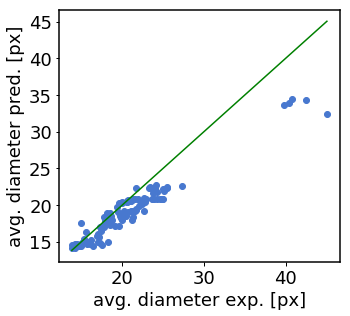

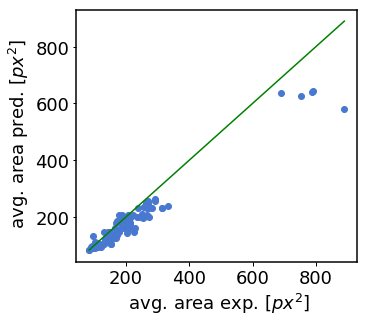

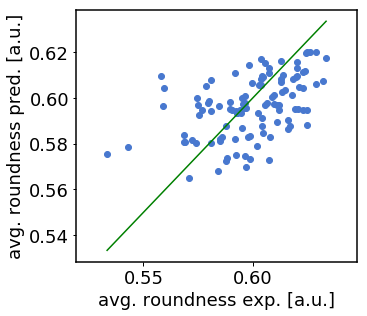

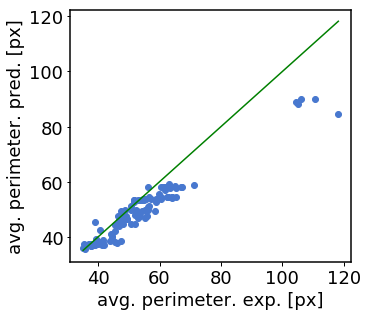

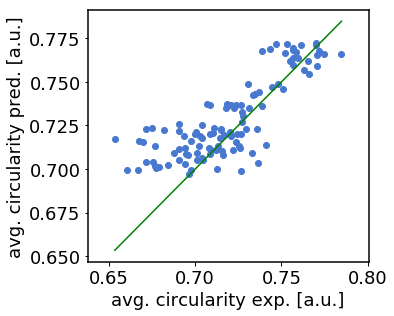

In [87]:
plt.rcParams.update({'font.size': 18,'xtick.major.width' : 1,'ytick.major.width' : 1,'axes.linewidth':1.5})
plt.style.use('seaborn-muted')

for attr,unit,title in zip(particle_attributes,units,axes_titles):
    plt.figure(figsize=(6.5,5))
    plt.scatter(hist_mean_orig[attr],hist_mean_pred[attr])
    min_=np.min(hist_mean_orig[attr])
    max_=np.max(hist_mean_orig[attr])
    plt.plot(np.linspace(min_,max_,10),np.linspace(min_,max_,10),c='green')
    plt.xlabel(title+' exp. ['+unit+']')
    plt.ylabel(title+' pred. ['+unit+']')
    plt.subplots_adjust(bottom=0.2, left=0.3, top=0.9)

    #plt.savefig(str(3)+attr+'.png',dpi=100)


### Compare histograms between original and predicted

mean: 63.99346860337426
std: 31.477012616322398
mean: 62.9047990063234
std: 30.38097590606


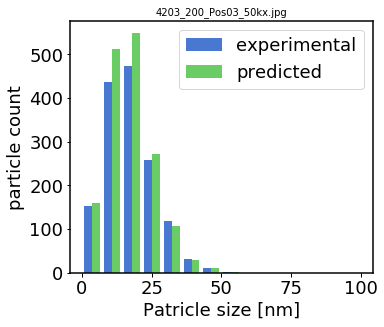

mean: 83.84986266170478
std: 46.46532850073779
mean: 70.79975388678791
std: 37.591620405046775


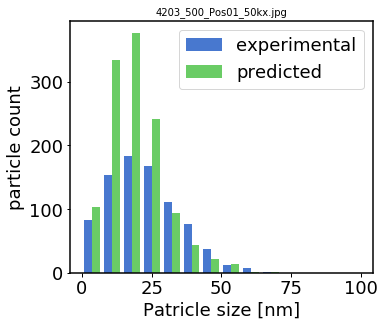

mean: 68.99468844320329
std: 30.705121153437123
mean: 66.02184985255161
std: 33.211275758701646


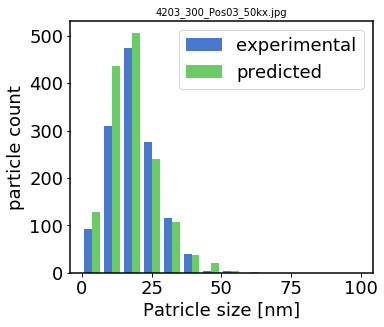

mean: 87.29166666666667
std: 54.13277966705252
mean: 82.53395493395493
std: 47.21725333416826


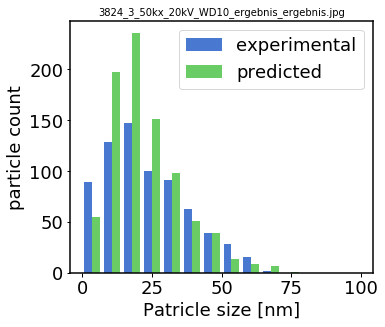

mean: 86.47740542150729
std: 49.72396195471566
mean: 82.86607684968341
std: 47.57031514815567


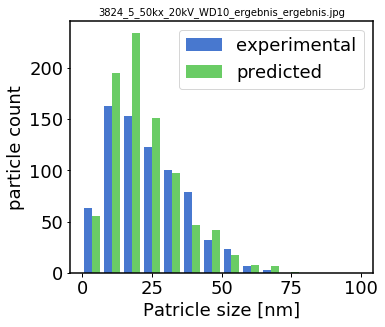

mean: 81.15736388097498
std: 41.58227004014549
mean: 76.96484165324746
std: 43.11105761227836


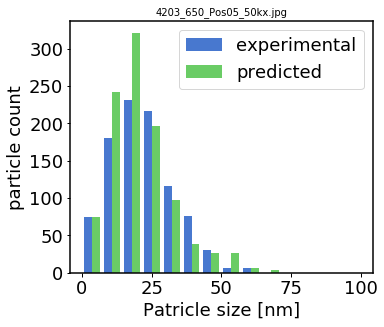

mean: 94.29399664875483
std: 53.39437577526986
mean: 82.60335796706858
std: 47.42381331881857


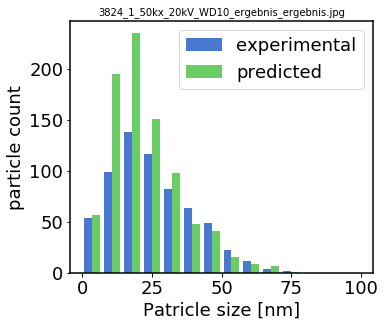

mean: 60.70028029322983
std: 30.7598022575479
mean: 53.50525471970024
std: 26.761320994530735


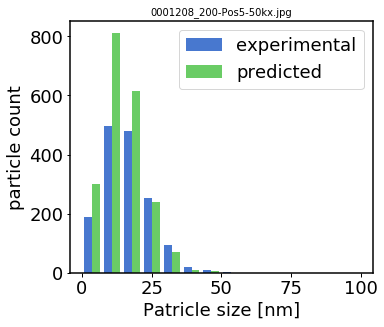

mean: 83.73154437456326
std: 50.796875709251516
mean: 77.66418032434291
std: 50.975448514568136


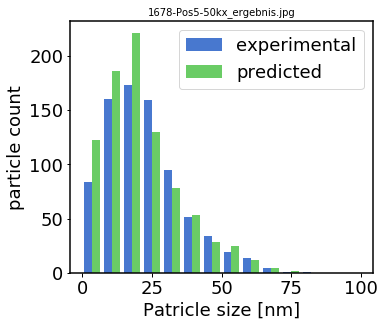

mean: 78.2847716991801
std: 36.691784122076236
mean: 76.62041292041292
std: 45.68098173881166


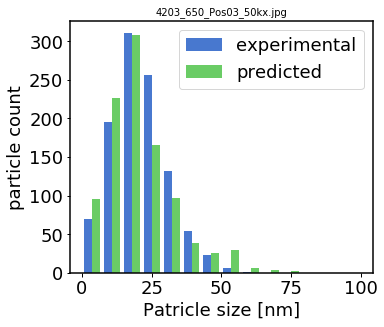

In [90]:
particle_attribute = 'Feret'
plt.style.use('seaborn-deep')
plt.style.use('seaborn-muted')
for f in classes_unique[np.random.randint(0,high=120,size = 10)]:
    fig = plt.figure(figsize=(6,5))
    hist_orig = []
    for i in range(len(classnames_orig)):
        if classnames_orig[i].rsplit('_',2)[0] == f:

            hist_orig.append(originals[i])
    hist_orig = pd.concat(hist_orig)
    print('mean: '+str(hist_orig[particle_attribute].mean(axis=0)/0.27))
    print('std: '+str(hist_orig[particle_attribute].std(axis=0)/0.27))

    hist_pred = []
    for i in range(len(classnames_orig)):
        if classnames_pred[i].rsplit('_',2)[0] == f:

            hist_pred.append(predicted[i])
    hist_pred = pd.concat(hist_pred)
    print('mean: '+str(hist_pred[particle_attribute].mean(axis=0)/0.27))
    print('std: '+str(hist_pred[particle_attribute].std(axis=0)/0.27))

    bins = np.linspace(0, 100, 15)

    plt.hist([hist_orig[particle_attribute], hist_pred[particle_attribute]], bins, label=['experimental', 'predicted'])
    plt.subplots_adjust(bottom=0.2, left=0.2, top=0.9)
    plt.legend(loc='upper right')
    plt.xlabel('Patricle size [nm]')
    plt.ylabel('particle count')
    plt.title(f,fontsize=10)
    plt.show()
